In [1]:
import numpy as np
import pickle

from boxes import *
from learner import *

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
PATH = "../data/ontologies/anatomy/"

with open(f'{PATH}human.pickle', 'rb') as handle:
    human = pickle.load(handle)
    
with open(f'{PATH}mouse.pickle', 'rb') as handle:
    mouse = pickle.load(handle)

with open(f'{PATH}entities.pickle', 'rb') as handle:
    entities = pickle.load(handle)
PATH = '../data/ontologies/anatomy/'

# aligment training split
ats = 0.8

# Transitive closure
Transitive_Closure = True

if Transitive_Closure:
    tc = "tc_"
else:
    tc = ""

# Data in unary.tsv are probabilites separated by newlines. The probability on line n is P(n), where n is the id assigned to the nth element.
unary_prob = torch.from_numpy(np.loadtxt(f'{PATH}unary/unary.tsv')).float().to("cpu")
num_boxes = unary_prob.shape[0]

# We're going to use random negative sampling during training, so no need to include negatives in our training data itself
train = Probs.load_from_julia(PATH, f'tr_pos_{tc}{ats}.tsv', f'tr_neg_{tc}{ats}.tsv', ratio_neg = 0).to("cpu")

# The dev set will have a fixed set of negatives, however.
dev = Probs.load_from_julia(PATH, f'dev_align_pos_{ats}.tsv', f'dev_align_neg_{ats}.tsv', ratio_neg = 1).to("cpu")

# This set is used just for evaluation purposes after training
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos_{ats}.tsv', f'tr_align_neg_{ats}.tsv', ratio_neg = 1).to("cpu")

In [3]:
#mPATH = "../results/MinMaxSigmoidBoxes_nEpochs50_lr0.01_dims10_ratio1_tc_split0.8_UnaryTrue0.01/model.pth"
mPATH = "../results/MinMaxSigmoidBoxes_nEpochs20_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.01/model.pth"

model_data = torch.load(mPATH)

model = BoxModel(
#     BoxParamType=DeltaBoxes,
    BoxParamType=MinMaxSigmoidBoxes,
    vol_func=soft_volume,
    num_models=1,
    num_boxes=num_boxes,
    dims=10,
    method="orig").to("cpu")

model.load_state_dict(model_data['state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: '../results/MinMaxSigmoidBoxes_nEpochs20_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.01/model.pth'

In [ ]:
# Get the coordinates of the boxes

beo = model(torch.tensor([[1, 1]]) )['box_embeddings_orig'].squeeze(0)

In [ ]:
print(model(torch.tensor([[4299, 52]]))['P(A|B)'].cpu().item())
print(model(torch.tensor([[52, 4299]]))['P(A|B)'].cpu().item())

In [ ]:
print(model(torch.tensor([[3380, 32]]))['P(A|B)'].cpu().item())
print(model(torch.tensor([[32, 3380]]))['P(A|B)'].cpu().item())

In [4]:
print(model(torch.tensor([[5357, 56]]))['P(A|B)'].cpu().item())
print(model(torch.tensor([[56, 5357]]))['P(A|B)'].cpu().item())

NameError: name 'model' is not defined

In [11]:
alignments = [(4299, 52),
              (3380, 32),
              (5357, 56),
              (4299, 52),
              (4299, 52),]




In [12]:
# row is a datapoint
# columns are dimensions
# [x1, y1]
# [x2, y2]

# one_node = points[0,:,:2]
# width = abs(one_node[1,0] - one_node[0,0])
# height = abs(one_node[1,1] - one_node[0,1])
# one_node_min = torch.min(one_node, dim=0).values.cpu().detach().numpy()
# one_node_min

In [13]:
def get_boxes(idx, color, dim=0):
    node = beo[idx,:,dim:dim+2].cpu().detach()
    
    width  = abs(node[1,0] - node[0,0])
    height = abs(node[1,1] - node[0,1])
    
    node_min = torch.min(node, dim=0).values
    
    rect = patches.Rectangle(node_min, width, height, linewidth=2, edgecolor=color, fill=True, facecolor=color, alpha=0.5)
    
    return rect, node_min[0].item(), node_min[1].item(), entities['idx2label'][idx.item()], width, height

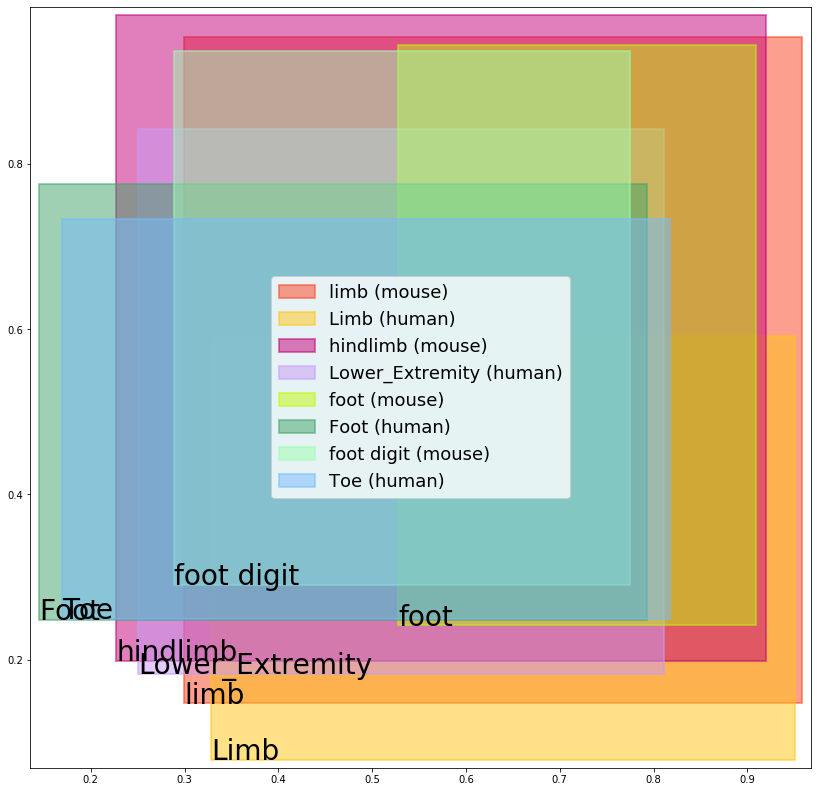

In [14]:
fig,ax = plt.subplots(1, figsize=(14,14), facecolor="white")

# box_idx = torch.tensor([4299, 52, 3380, 32, 5357, 56, 3030, 2784, 44, 732, 58, 4298, 5779, 5830])
# box_idx = torch.tensor([3030, 732, 5779, 5830, 4299, 52, 3380, 32, 5357, 56])
# box_idx = torch.tensor([1, 4299, 52, 3380, 32, 5357, 56, 58])
# box_idx = torch.tensor([3380, 3377, 3382, 3471, 4299, 4746, 4982])
# box_idx = torch.tensor([1, 2738, 6, 2784, 5014])
# box_idx = torch.tensor([1, 6, 5, 8, 69])
box_idx = torch.tensor([11, 3030, 32, 3380, 52, 4299, 56, 5357])

# colors = list(mcolors.CSS4_COLORS)
colors = ['xkcd:orange red', 'xkcd:sunflower', 'xkcd:magenta', 'xkcd:baby purple',
          'xkcd:chartreuse',  'xkcd:greenish', 'xkcd:mint', 'xkcd:sky blue',
           'xkcd:slate blue', 'xkcd:deep red', 'xkcd:greyish brown', 'xkcd:canary yellow' ]

rectangles = []
labels = []

# rect1 = patches.Rectangle(one_node_min, width, height,linewidth=2,edgecolor='r', fill=True, facecolor='r', alpha=0.3)
# rect2 = patches.Rectangle((0.5,0.1),.1,.3,linewidth=2,edgecolor='b', fill=True, facecolor='b', alpha=0.3)
left = 100
right = -100
top = -100
bottom = 100
# 0, 4
for i, bidx in enumerate(box_idx):
    rect, xmin, ymin, name, w, h = get_boxes(bidx, colors[i], dim=6)
    if xmin < left:
        left = xmin
    if ymin < bottom:
        bottom = ymin
    if xmin + w > right:
        right = xmin+w
    if ymin + h > top:
        top = ymin+h
    
    ax.text(xmin, ymin, entities['idx2label'][bidx.item()], fontsize=28)
    ax.add_patch(rect)
    
    if bidx.item() < 2738:
        labels.append(name + " (mouse)")
    else:
        labels.append(name + " (human)")

# ax.add_patch(rect2)

# ax.set_xlim([-.1, 1.5])
# ax.set_ylim([-.1, 1.5])

ax.set_xlim([left-0.01, right+0.01])
ax.set_ylim([bottom-0.01, top+0.01])

ax.legend(labels, fontsize=18, loc=10)
plt.show()



In [15]:
print( [(p, entities['idx2label'][p]) for p in mouse['children_of'][1] ] )
# print( [(p, entities['idx2label'][p]) for p in human['children_of'][5014] ] )

#             1
#             |
#     ________6________
#    /        |        \
#   5   ______8_____   69
#      /   /  |  \  \
#     7   9  10  11  12

x = model(torch.tensor([[69,6],
                        [6,69]]))['P(A|B)']

print("",x[0].item(),"\n", x[1].item())

# print(model(torch.tensor([[1,6],[6,1]]))['P(A|B)'])
# print(model(torch.tensor([[6,1]]))['P(A|B)'])

[(6, 'adult mouse')]
 0.5328575968742371 
 0.6015654802322388


In [16]:
entities['idx2name'][8]

'MA_0002433'

In [17]:
entities['name2idx']['NCI_C13236']

3037

In [18]:
print('limb', entities['label2idx']['limb'])
print('Limb', entities['label2idx']['Limb'])
print('hindlimb', entities['label2idx']['hindlimb'])
print('Lower_Extremity', entities['label2idx']['Lower_Extremity'])
print('foot', entities['label2idx']['foot'])
print('Foot', entities['label2idx']['Foot'])
print('foot digit', entities['label2idx']['foot digit'])
print('Toe', entities['label2idx']['Toe'])

limb 11
Limb 3030
hindlimb 32
Lower_Extremity 3380
foot 52
Foot 4299
foot digit 56
Toe 5357


In [19]:
print("limb given Limb {:.3f}".format(model(torch.tensor([[11, 3030]]))['P(A|B)'].cpu().item()))
print("Limb given limb {:.3f}".format(model(torch.tensor([[3030, 11]]))['P(A|B)'].cpu().item()))

print("hindlimb given Lower_Extremity {:.3f}".format(model(torch.tensor([[32, 3380]]))['P(A|B)'].cpu().item()))
print("Lower_Extremity  given hindlimb {:.3f}".format(model(torch.tensor([[3380, 32]]))['P(A|B)'].cpu().item()))

print("foot given Foot {:.3f}".format(model(torch.tensor([[52, 4299]]))['P(A|B)'].cpu().item()))
print("Foot given foot {:.3f}".format(model(torch.tensor([[4299, 52]]))['P(A|B)'].cpu().item()))

print("foot digit given Toe {:.3f}".format(model(torch.tensor([[56, 5357]]))['P(A|B)'].cpu().item()))
print("Toe given foot digit {:.3f}".format(model(torch.tensor([[5357, 56]]))['P(A|B)'].cpu().item()))

limb given Limb 0.662
Limb given limb 0.381
hindlimb given Lower_Extremity 0.607
Lower_Extremity  given hindlimb 0.431
foot given Foot 0.480
Foot given foot 0.431
foot digit given Toe 0.321
Toe given foot digit 0.260
